# Bitcoin Price Prediction with Regression Models

This notebook implements Linear Regression, Ridge Regression, and Lasso Regression models to predict Bitcoin prices using the preprocessed data.

Authors: Hoda Abokhadra, Philip Myint, Bryan Reynolds, Taha Wasiq 

In [1]:
import importlib
import BitcoinModeler

import importlib
importlib.reload(BitcoinModeler)

from BitcoinModeler import *


In [2]:
# Use LaTeX fonts for figures and set font size of tick labels.
plt.rc('text', usetex=True)
plt.rc('font', family='serif', weight='bold')
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
# Hex codes of Matplotlib Tableau color palette: blue, orange, green, red, purple, brown, pink, gray, olive, cyan. 
plot_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# XKCD colors (https://xkcd.com/color/rgb/): teal, magenta, sea green, bright pink, dark orange, goldenrod, forest, dirt, coral, baby blue, peach.
plot_colors.extend(['#029386', '#c20078', '#53fca1', '#fe01b1', '#c65102', '#fac205', '#0b5509', '#8a6e45', '#fc5a50', '#a2cffe', '#ffb07c'])

# Define the directory to place plots/figures generated in this script.
plot_dir = './../report/figures/'

# Bitcoin Price Prediction

This notebook trains simple linear models for BTC price horizons **H1** (1 day) and **H7** (7 days), evaluates them on **Train/Validation/Test**, plots performance


## 🧱 Data & Splits

We load preprocessed CSVs for both horizons:

- **Train**: used to fit model parameters  
- **Validation (val)**: used to choose models/hyperparameters (no peeking at Test)  
- **Test**: used once at the end for an unbiased performance estimate




In [3]:
# Load h1 data
data_dir = './../data/processed/'
h1_train = pd.read_csv(data_dir + 'h1_vif_train.csv')
h1_val = pd.read_csv(data_dir + 'h1_vif_val.csv')
h1_test = pd.read_csv(data_dir + 'h1_vif_test.csv')

# Load h7 data
h7_train = pd.read_csv(data_dir + 'h7_vif_train.csv')
h7_val = pd.read_csv(data_dir + 'h7_vif_val.csv')
h7_test = pd.read_csv(data_dir + 'h7_vif_test.csv')

print(f"H1 - Train: {h1_train.shape}, Val: {h1_val.shape}, Test: {h1_test.shape}")
print(f"H7 - Train: {h7_train.shape}, Val: {h7_val.shape}, Test: {h7_test.shape}")

H1 - Train: (1877, 60), Val: (402, 60), Test: (403, 60)
H7 - Train: (1873, 60), Val: (401, 60), Test: (402, 60)


In [4]:
bundle_h1=BitcoinModeler.DataManager.prepare(h1_train, h1_val, h1_test, "y_btc_close_t+1", r"h=1")
bundle_h7=BitcoinModeler.DataManager.prepare(h7_train, h7_val, h7_test, "y_btc_close_t+7", r"h=7")

> Note: Features are **already z-score normalized using train-only stats** in `split.py` to avoid leakage.

In [5]:
# optional if you want to compare scaled vs unscaled 
#scaler_h1_cls = ScalerManager()
#bundle_h1_scaled = scaler_h1_cls.scale_bundle(bundle_h1)

#scaler_h7_cls = ScalerManager()
#bundle_h7_scaled = scaler_h7_cls.scale_bundle(bundle_h7)
#print("Class-based DataBundle objects created (both raw and scaled variants).")


## 🚀 Model Runs

We fit all three models on **H1 (1-day)** and **H7 (7-day)** horizons, then print per-split metrics.


In [6]:
# === Run experiments
importlib.reload(BitcoinModeler)
runner_h1 = BitcoinModeler.ExperimentRunner(bundle_h1, scaled=True)
df_h1 = runner_h1.run()

runner_h7 = BitcoinModeler.ExperimentRunner(bundle_h7, scaled=True)
df_h7 = runner_h7.run()


Bundle:  h=1 Spline columns (selected): ['btc_atr14', 'btc_macd', 'btc_roll_std_close_7', 'btc_rsi14']
Bundle:  h=1 Passthrough features     : 54
Bundle:  h=1 Best params: {'pre__spl__n_knots': 8, 'ridge__alpha': 91.18425196146562} | Val MSE: 634.5138004960418
Bundle:  h=7 Spline columns (selected): ['btc_atr14', 'btc_macd', 'btc_roll_std_close_7', 'btc_rsi14']
Bundle:  h=7 Passthrough features     : 54
Bundle:  h=7 Best params: {'pre__spl__n_knots': 8, 'ridge__alpha': 37.59674965785467} | Val MSE: 3075.070228327343


## 📊 Results Table (All Models × Splits)


In [7]:

# Merge all for a single summary table 
results_df_classes = pd.concat([df_h1, df_h7], ignore_index=True)
print("\n——— CLASS-BASED RESULTS SUMMARY ———\n")
print(results_df_classes.to_string(index=False, float_format="%.6f"))


——— CLASS-BASED RESULTS SUMMARY ———

Horizon               Model    Dataset            MSE        RMSE         MAE  RMSE_ND   MAE_ND       R2
    h=1              Linear   Training     267.349134   16.350814    8.792502 0.070941 0.038148 0.994967
    h=1              Linear Validation    4946.599768   70.332068   57.006248 0.465946 0.377663 0.782894
    h=1              Linear       Test 1544242.443763 1242.675518  795.161294 0.269260 0.172294 0.927499
    h=1               Ridge   Training     271.792234   16.486122    8.792883 0.071528 0.038150 0.994884
    h=1               Ridge Validation    3861.436130   62.140455   49.692989 0.411677 0.329213 0.830522
    h=1               Ridge       Test 1255825.040431 1120.635998  699.768869 0.242817 0.151624 0.941040
    h=1               Lasso   Training     301.820819   17.372991    8.811656 0.075376 0.038231 0.994318
    h=1               Lasso Validation    5263.245426   72.548228   61.238193 0.480628 0.405700 0.768997
    h=1          

## 📈 Lasso Performance — Validation vs Test

The chart below compares **Nonzero** vs **Zero** coefficients for each horizon (H1, H7).  



In [8]:
# Feature importance for Lasso models
lasso_h1 = [m for m in runner_h1.models if m.name == "Lasso"][0]
lasso_h7 = [m for m in runner_h7.models if m.name == "Lasso"][0]
H1LassoModelWrap = ModelWrapper(r"h=1", lasso_h1.model)
H7LassoModelWrap = ModelWrapper(r"h=7", lasso_h7.model)

Feature Importance Analysis
Magnitude of the coefficients are: 155.997961758575


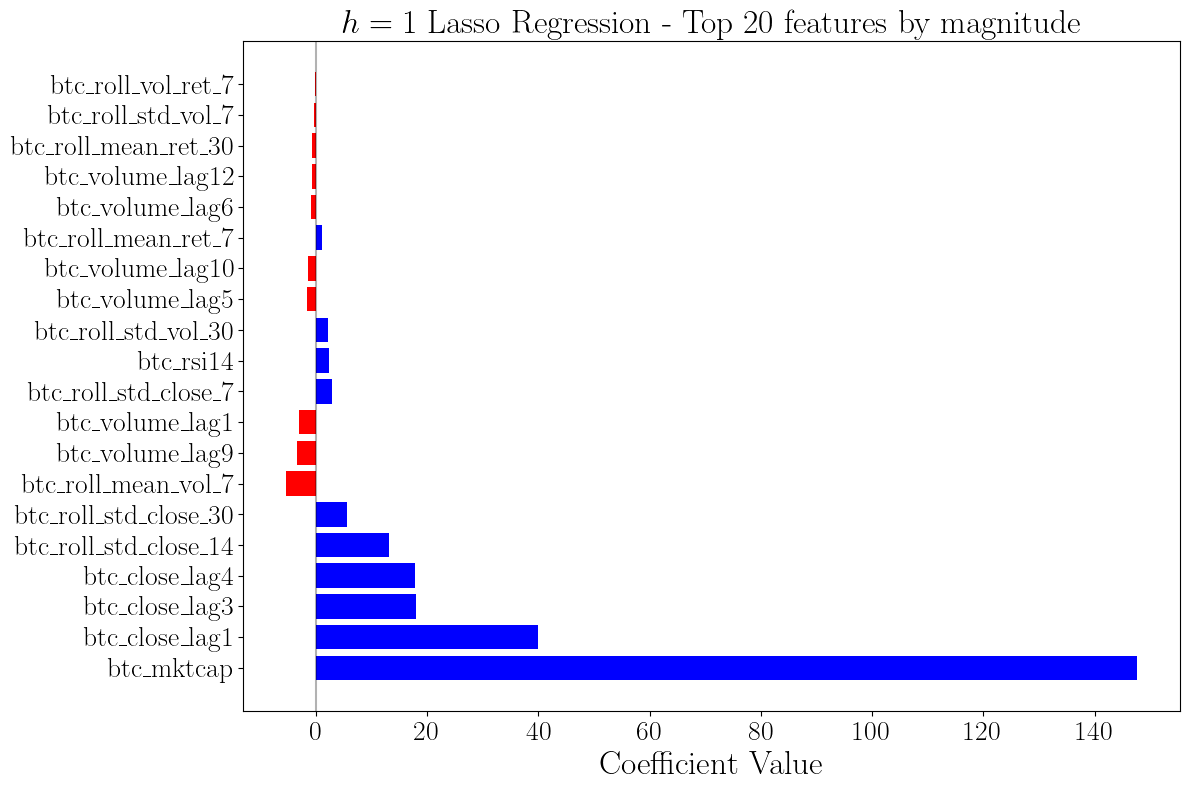

Magnitude of the coefficients are: 162.13923389916582


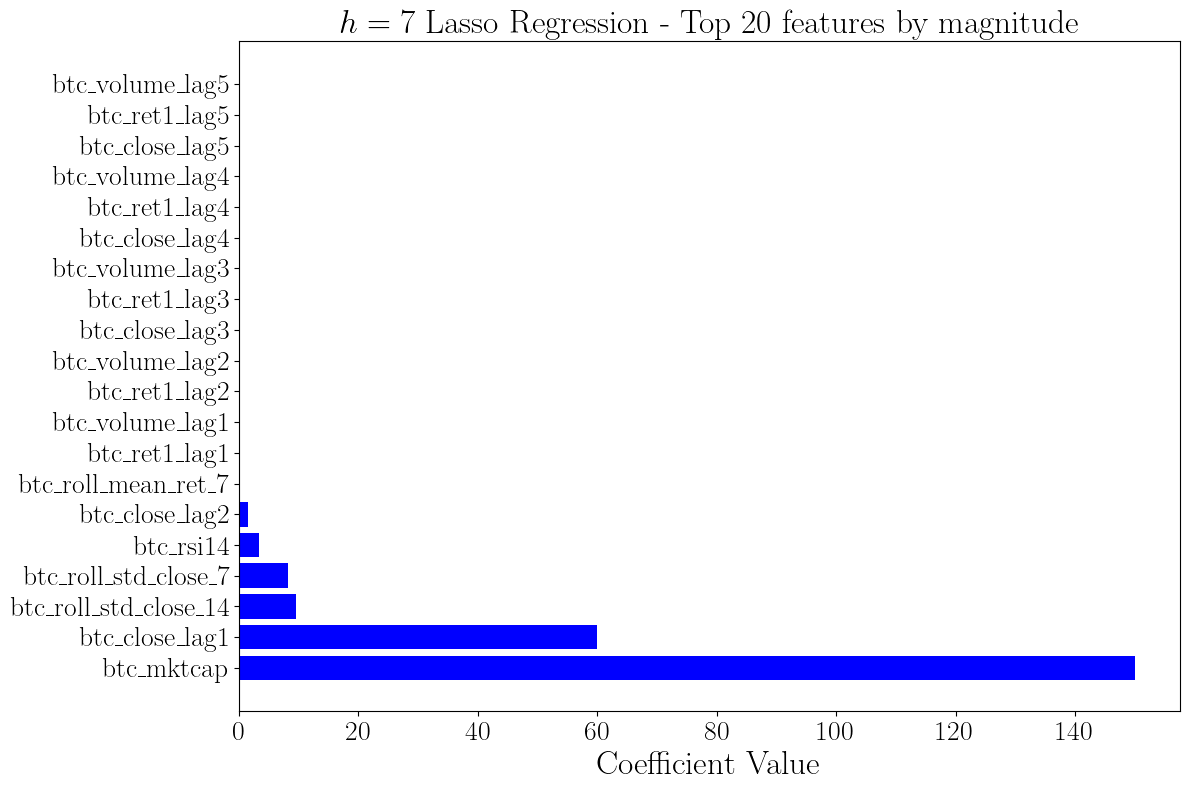

In [9]:
print("Feature Importance Analysis")
print("="*50)
# H1 Lasso
h1_lasso_features = H1LassoModelWrap.plot_feature_importance(bundle_h1.feature_cols, rf'$h=1$ Lasso Regression', plot_name=plot_dir+'h1_lasso_coefs.pdf')
# H7 Lasso  
h7_lasso_features = H7LassoModelWrap.plot_feature_importance(bundle_h7.feature_cols, rf'$h=7$ Lasso Regression', plot_name=plot_dir+'h7_lasso_coefs.pdf')

## 📈 Ridge Performance — Validation vs Test

In [10]:
# Feature importance for Ridge models
ridge_h1 = [m for m in runner_h1.models if m.name == "Ridge"][0]
ridge_h7 = [m for m in runner_h7.models if m.name == "Ridge"][0]
H1RidgeModelWrap = ModelWrapper("h=1", ridge_h1.model)
H7RidgeModelWrap = ModelWrapper("h=7", ridge_h7.model)

Feature Importance Analysis
Magnitude of the coefficients are: 153.71288150122953


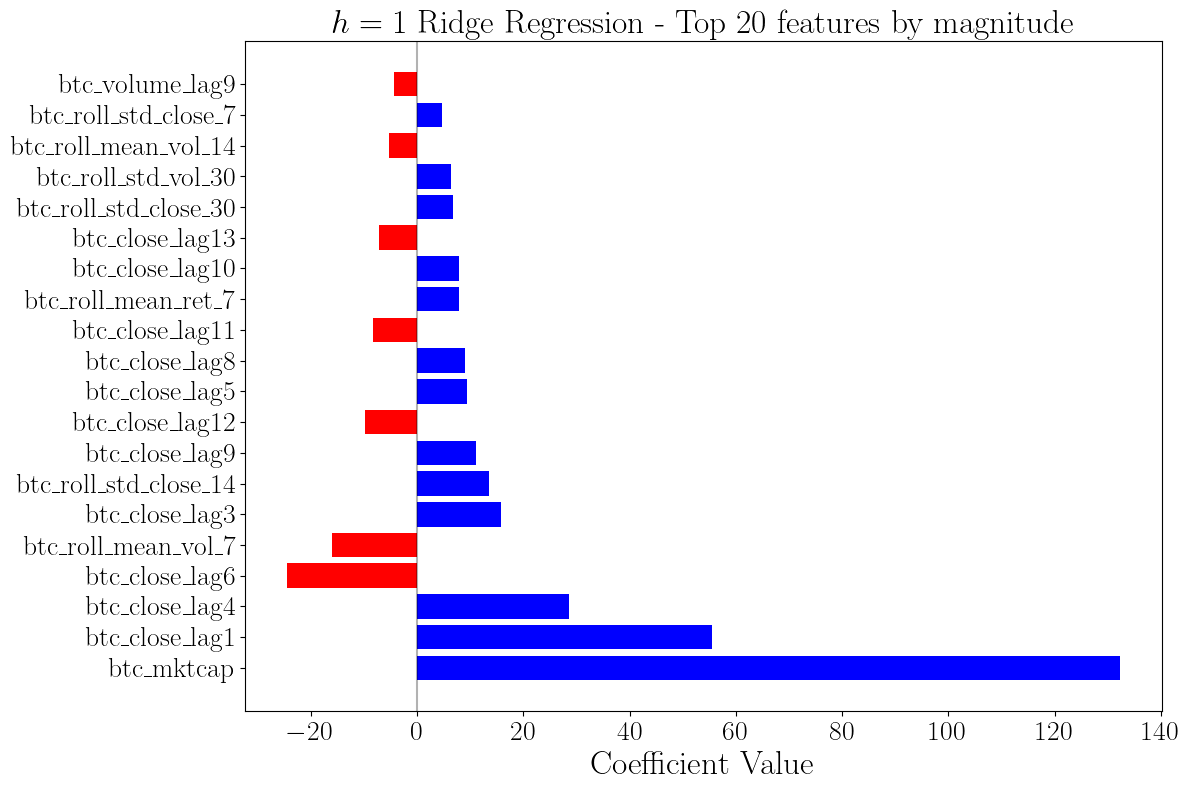

Magnitude of the coefficients are: 164.57800448758357


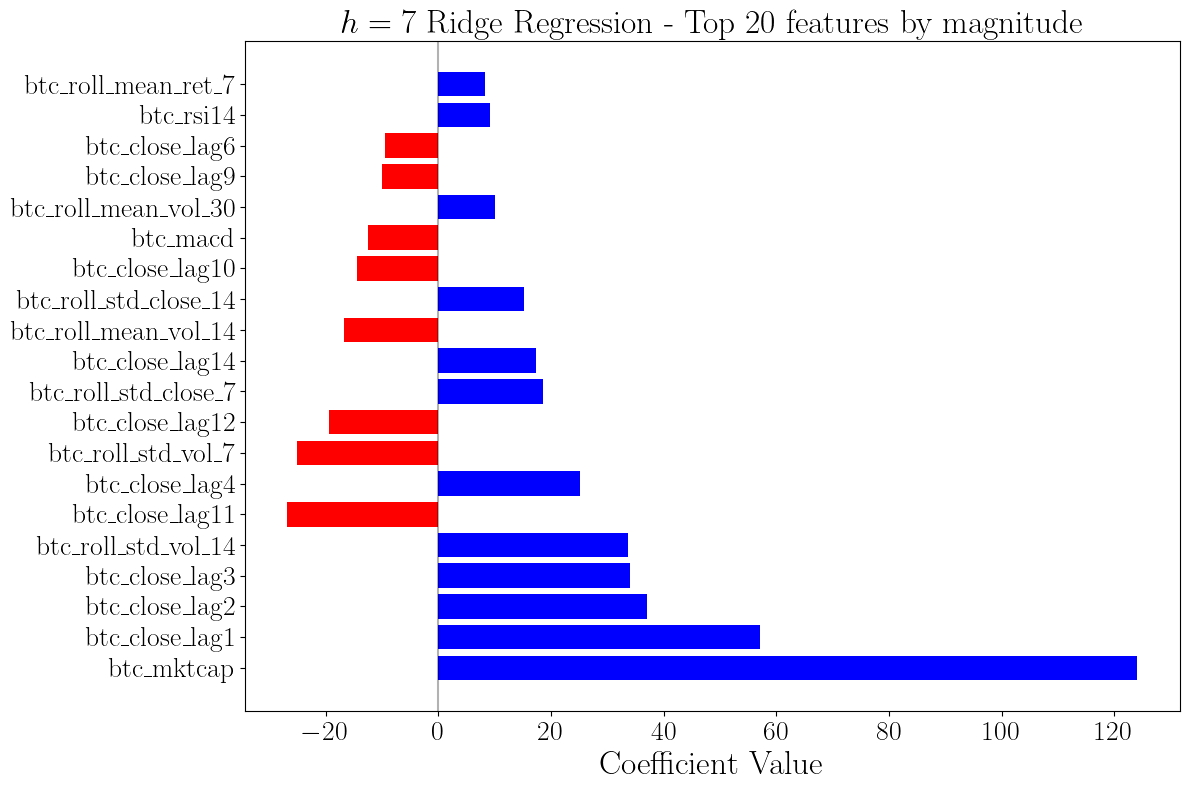

In [11]:
print("Feature Importance Analysis")
print("="*50)
# H1 Ridge
h1_ridge_features = H1RidgeModelWrap.plot_feature_importance(bundle_h1.feature_cols, rf'$h=1$ Ridge Regression', plot_name=plot_dir+'h1_ridge_coefs.pdf')
# H7 Ridge  
h7_ridge_features = H7RidgeModelWrap.plot_feature_importance(bundle_h7.feature_cols, rf'$h=7$ Ridge Regression', plot_name=plot_dir+'h7_ridge_coefs.pdf')

## 📈 Linear Performance — Validation vs Test

In [12]:
# Feature importance for Linear models
linear_h1 = [m for m in runner_h1.models if m.name == "Linear"][0]
linear_h7 = [m for m in runner_h7.models if m.name == "Linear"][0]
H1LinearModelWrap = ModelWrapper("h=1", linear_h1.model)
H7LinearModelWrap = ModelWrapper("h=7", linear_h7.model)

Feature Importance Analysis
Magnitude of the coefficients are: 179.83599855739823


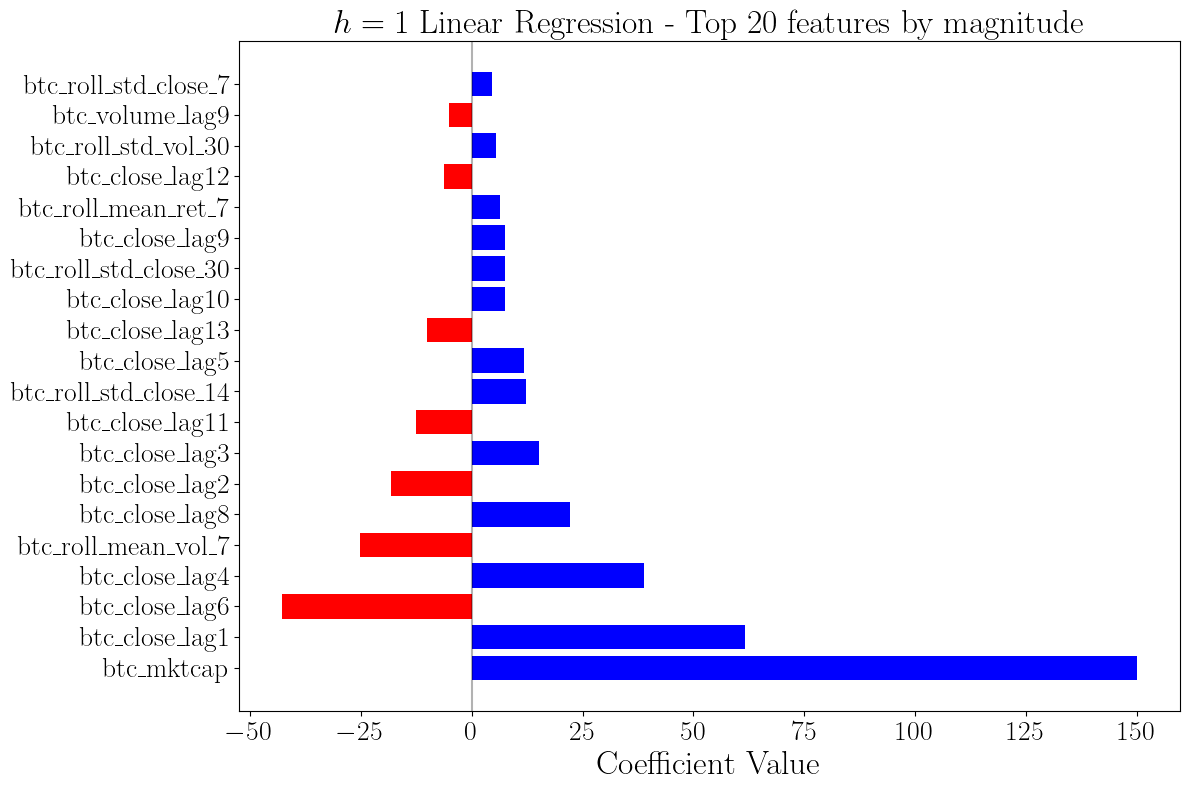

Magnitude of the coefficients are: 241.1342696145422


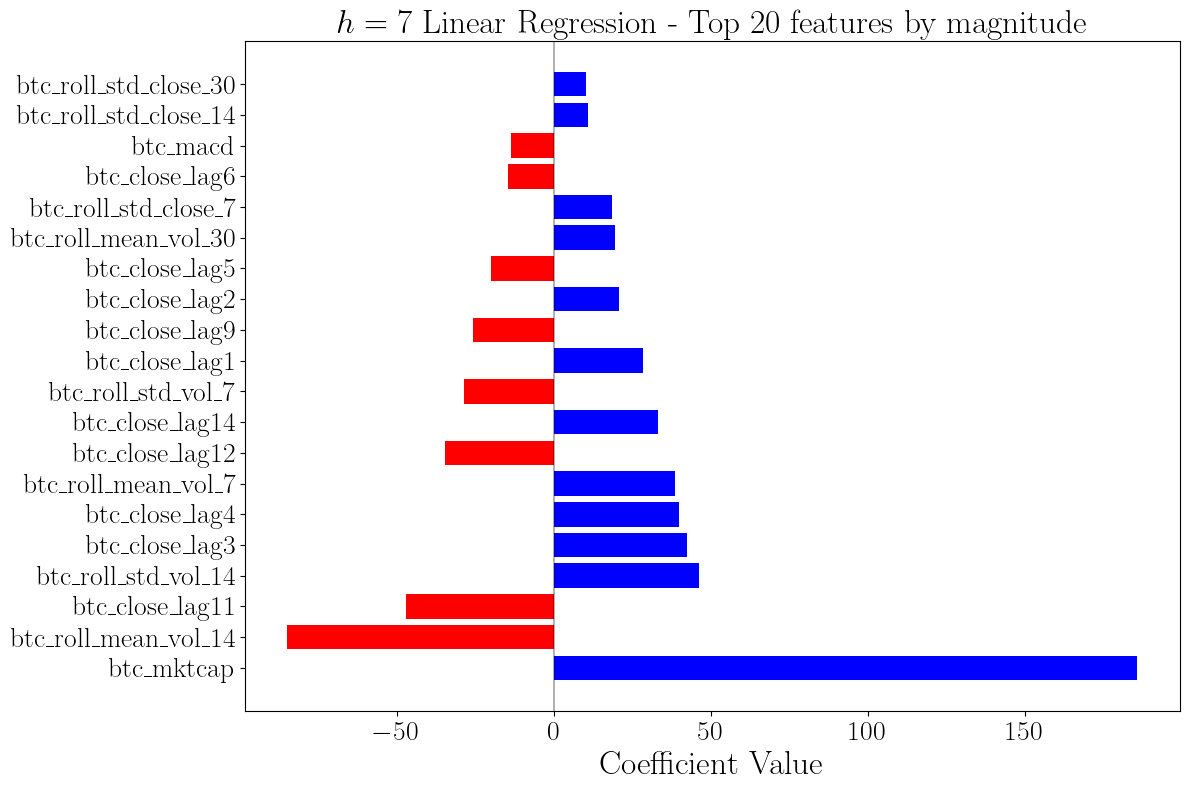

In [13]:
print("Feature Importance Analysis")
print("="*50)
# H1 Linear
h1_linear_features = H1LinearModelWrap.plot_feature_importance(bundle_h1.feature_cols, rf'$h=1$ Linear Regression', plot_name=plot_dir+'h1_linear_coefs.pdf')
# H7 Linear
h7_linear_features = H7LinearModelWrap.plot_feature_importance(bundle_h7.feature_cols, rf'$h=7$ Linear Regression', plot_name=plot_dir+'h7_linear_coefs.pdf')

## 🏆 Best Model Summary (Chosen by Validation RMSE)

For **each horizon**, we pick the model  with the **lowest Validation RMSE**, then report its **R2** and **Test_MSE** metrics.  



In [14]:
# -- Produce and print the best-model summary (pick by Validation RMSE; show Test metrics)
best_summary = ModelWrapper.best_summary(results_df_classes, metric="RMSE", prefer_scaled=None)
print("\n" + "="*80)
print("BEST MODEL SUMMARY — picked by lowest Validation RMSE; Test metrics shown")
print("="*80)
print(best_summary.to_string(index=False, float_format="%.6f"))
print("\n" + "="*80)
print("BEST MODEL SUMMARY — picked by lowest Validation R2; Test metrics shown")
print("="*80)
best_summaryR2 = ModelWrapper.best_summary(results_df_classes, metric="R2", prefer_scaled=None)
print(best_summaryR2.to_string(index=False, float_format="%.6f"))

H1LassoNonZeroCoef = H1LassoModelWrap.get_lasso_nonzero_coef()
H7LassoNonZeroCoef = H7LassoModelWrap.get_lasso_nonzero_coef()
result = (
    f"h=1: {H1LassoNonZeroCoef}/{len(bundle_h1.feature_cols)} features selected | "
    f"h=7: {H7LassoNonZeroCoef}/{len(bundle_h7.feature_cols)} features selected"
)
print("\nLasso coefficients (the rest are shrunk to zero): ",result)




BEST MODEL SUMMARY — picked by lowest Validation RMSE; Test metrics shown
Horizon               Model  Val_RMSE            MSE        RMSE        MAE  RMSE_ND   MAE_ND       R2
    h=1 B-Spline with Ridge 25.189557  558335.472831  747.218491 390.790110 0.161906 0.084676 0.973787
    h=7 B-Spline with Ridge 55.453316 1893377.790031 1376.000650 769.819472 0.298091 0.166770 0.911142

BEST MODEL SUMMARY — picked by lowest Validation R2; Test metrics shown
Horizon               Model   Val_R2            MSE        RMSE        MAE  RMSE_ND   MAE_ND       R2
    h=1 B-Spline with Ridge 0.972151  558335.472831  747.218491 390.790110 0.161906 0.084676 0.973787
    h=7 B-Spline with Ridge 0.865529 1893377.790031 1376.000650 769.819472 0.298091 0.166770 0.911142

Lasso coefficients (the rest are shrunk to zero):  h=1: 20/58 features selected | h=7: 7/58 features selected


## 🧭 Baselines & Diagnostics 
  1. Compare model performance across different prediction timeframes
  2. Regularization effects of Ridge vs Lasso regression
  3. Feature selection capabilities of Lasso regression
  4. Model stability across validation and test sets


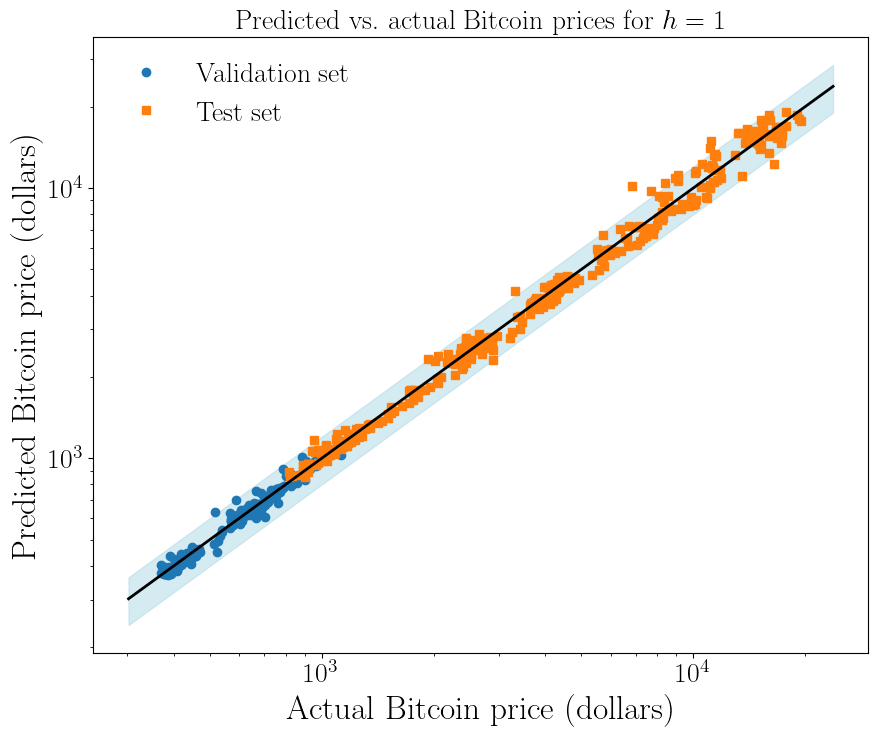

In [15]:
# Create a plot of actual vs. predicted Bitcoin prices for the best h = 1 model, which is the B-spline + Ridge regression model.
bundle = bundle_h1
best_h1 = [m for m in runner_h1.models if m.name == "B-Spline with Ridge"][0]
yhat_val = best_h1.predict(bundle.X_val)
yhat_test = best_h1.predict(bundle.X_test)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(bundle.y_val, yhat_val, 'o', color=plot_colors[0], label='Validation set')
ax.plot(bundle.y_test, yhat_test, 's', color=plot_colors[1], label='Test set')
ax.set_xscale('log')
ax.set_yscale('log')
# Add black line for y = x, representing a perfect fit.
min_val = min(ax.get_xlim()[0], ax.get_ylim()[0])
max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
x_line = np.linspace(min_val, max_val, 100) 
ax.plot(x_line, x_line, color='k', linewidth=2)
error = 0.2
plt.fill_between(x_line, x_line - error*x_line, x_line + error*x_line, color='lightblue', alpha=0.5)
ax.set_xlabel('Actual Bitcoin price (dollars)', fontsize=24)
ax.set_ylabel('Predicted Bitcoin price (dollars)', fontsize=24)
ax.set_title(rf'Predicted vs.\ actual Bitcoin prices for $h=1$', fontsize=20)
ax.legend(prop={'size': 20}, frameon=False, loc='best', ncol=1)
fig.set_size_inches(10, 8)
fig.savefig(plot_dir+'actual_vs_predicted_h1.pdf', format='pdf', bbox_inches='tight')

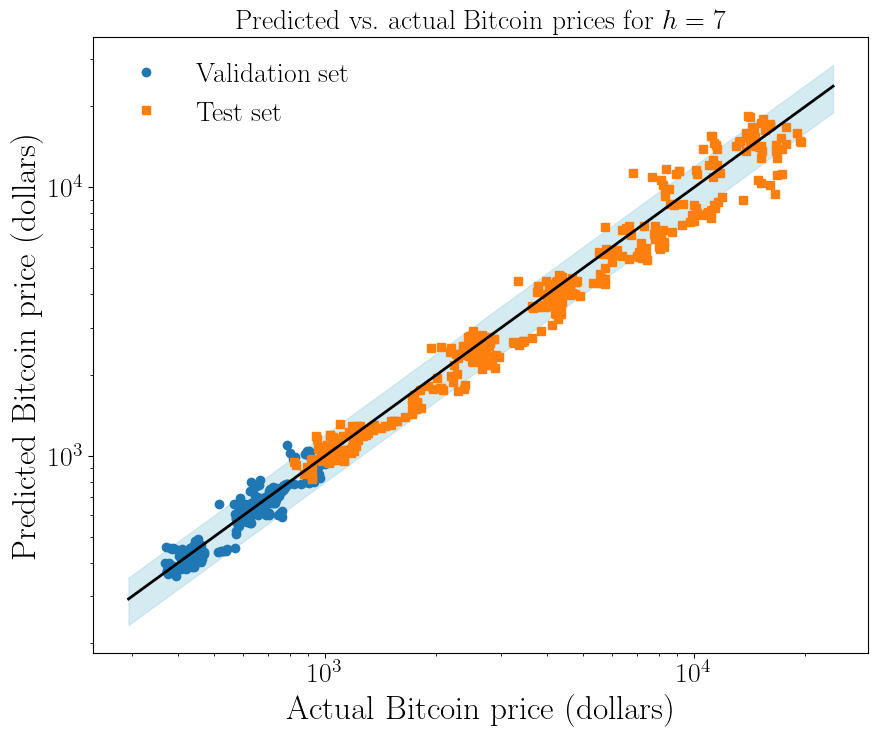

In [16]:
# Create a plot of actual vs. predicted Bitcoin prices for the best h = 7 model, which is the the B-spline + Ridge regression model.
bundle = bundle_h7
best_h7 = [m for m in runner_h7.models if m.name == "B-Spline with Ridge"][0]
yhat_train = best_h7.predict(bundle.X_train)
yhat_val = best_h7.predict(bundle.X_val)
yhat_test = best_h7.predict(bundle.X_test)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(bundle.y_val, yhat_val, 'o', color=plot_colors[0], label='Validation set')
ax.plot(bundle.y_test, yhat_test, 's', color=plot_colors[1], label='Test set')
ax.set_xscale('log')
ax.set_yscale('log')
# Add black line for y = x, representing a perfect fit.
min_val = min(ax.get_xlim()[0], ax.get_ylim()[0])
max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
x_line = np.linspace(min_val, max_val, 100) 
ax.plot(x_line, x_line, color='k', linewidth=2)
error = 0.2
plt.fill_between(x_line, x_line - error*x_line, x_line + error*x_line, color='lightblue', alpha=0.5)
ax.set_xlabel('Actual Bitcoin price (dollars)', fontsize=24)
ax.set_ylabel('Predicted Bitcoin price (dollars)', fontsize=24)
ax.set_title(rf'Predicted vs.\ actual Bitcoin prices for $h=7$', fontsize=20)
ax.legend(prop={'size': 20}, frameon=False, loc='best', ncol=1)
fig.set_size_inches(10, 8)
fig.savefig(plot_dir+'actual_vs_predicted_h7.pdf', format='pdf', bbox_inches='tight')

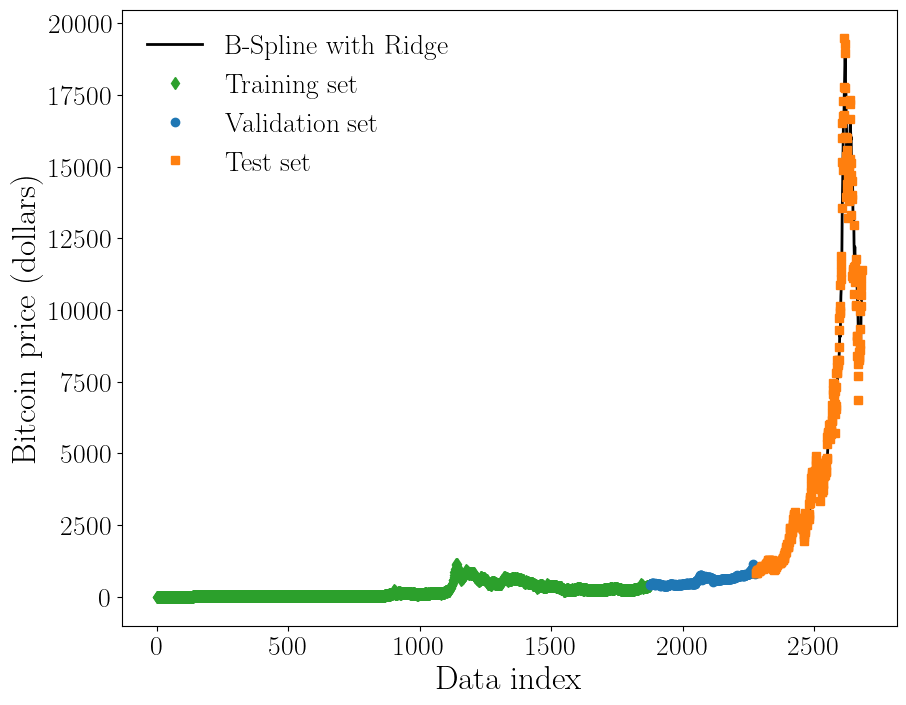

In [17]:
# Create a time series plot of prices.
bundle = bundle_h1
X = pd.concat([bundle.X_train, bundle.X_val, bundle.X_test])
data = pd.concat([h1_train, h1_val, h1_test])
yhat = best_h1.predict(X)
n_train = bundle.X_train.shape[0]
n_val = bundle.X_val.shape[0]
n_test = bundle.X_test.shape[0]

fig, ax = plt.subplots(nrows=1, ncols=1)
indices = np.linspace(0, data.shape[0], data.shape[0])
ax.plot(indices, yhat, color='k', linestyle='-', linewidth=2, label='B-Spline with Ridge')
ax.plot(indices[:n_train], bundle.y_train, 'd', color=plot_colors[2], label='Training set')
ax.plot(indices[n_train:n_train+n_val], bundle.y_val, 'o', color=plot_colors[0], label='Validation set')
ax.plot(indices[n_train+n_val:len(indices)], bundle.y_test, 's', color=plot_colors[1], label='Test set')
ax.set_xlabel('Data index', fontsize=24)
ax.set_ylabel('Bitcoin price (dollars)', fontsize=24)
#ax.set_title(rf'Residuals vs.\ actual Bitcoin prices', fontsize=20)
ax.legend(prop={'size': 20}, frameon=False, loc='best', ncol=1)
fig.set_size_inches(10, 8)
fig.savefig(plot_dir+'bitcoin_prices_h1.pdf', format='pdf', bbox_inches='tight')